**Idea**: Implement Context Encoder + SRCNN  
**Framework**: Keras-Core  
**Date**: 02/11/2023  

In [1]:
'general use imports'
import os
import wget
import tarfile
import numpy as np

import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.util import img_as_float

'machine learning imports'
import keras_core as keras
os.environ["KERAS_BACKEND"] = "tensorflow"

Using TensorFlow backend


### Data

In [ ]:
# Downloading the data
url_voc = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
os.makedirs(os.path.join(".", "data_voc2007"), exist_ok=True)
wget.download(url = url_voc, out = "data_voc2007")

# Extracting the data
tar = tarfile.open("data_voc2007/VOCtrainval_06-Nov-2007.tar")
tar.extractall("data_voc2007")
tar.close()
os.remove("data_voc2007/VOCtrainval_06-Nov-2007.tar")

'data_voc2007/VOCtrainval_06-Nov-2007.tar'

In [ ]:
# Extracting the data
tar = tarfile.open("data_voc2007/VOCtrainval_06-Nov-2007.tar")
tar.extractall("data_voc2007")
tar.close()
os.remove("data_voc2007/VOCtrainval_06-Nov-2007.tar")

In [22]:
class UNet(keras.Model):
    """	
    U-Net model class.
    """
    def __init__(self, conv_type='Conv2D', activation='LeakyReLU', 
    residual=False, attention=False, filters=64, filter_size=3, num_classes=1):
        super(UNet, self).__init__()
        self.conv_type = conv_type
        self.activation = activation
        self.residual = residual
        self.attention = attention
        self.filters = filters
        self.filter_size = filter_size
        self.num_classes = num_classes

    def call(self, inputs, training=False):
        # Encoder
        x = self.conv_block(inputs, self.filters, self.filter_size)
        p1 = self.conv_block(x, self.filters*2, self.filter_size)
        p2 = self.conv_block(p1, self.filters*4, self.filter_size)
        p3 = self.conv_block(p2, self.filters*8, self.filter_size)

        # Bottleneck
        x = self.conv_block(p3, self.filters*16, self.filter_size)

        # Decoder
        x = self.up_conv(x, self.filters*8, self.filter_size)
        x = Concatenate(axis=-1)([x, p3])
        x = self.conv_block(x, self.filters*8, self.filter_size)

        x = self.up_conv(x, self.filters*4, self.filter_size)
        x = Concatenate(axis=-1)([x, p2])
        x = self.conv_block(x, self.filters*4, self.filter_size)

        x = self.up_conv(x, self.filters*2, self.filter_size)
        x = Concatenate(axis=-1)([x, p1])
        x = self.conv_block(x, self.filters*2, self.filter_size)

        x = self.up_conv(x, self.filters, self.filter_size)
        x = Concatenate(axis=-1)([x, inputs])
        x = self.conv_block(x, self.filters, self.filter_size)

        # Output
        activation = 'sigmoid' if self.num_classes == 1 else 'softmax'
        outputs = Conv2D(self.num_classes, (1, 1), activation=activation)(x)

        return outputs

    def conv_block(self, inputs, filters, filter_size):
        x = self.conv_layer(inputs, filters, filter_size)
        x = Activation(self.activation)(x)
        x = self.conv_layer(x, filters, filter_size)
        x = Activation(self.activation)(x)
        return x

    def conv_layer(self, inputs, filters, filter_size):
        if self.conv_type == 'Conv2D':
            return Conv2D(filters, (filter_size, filter_size), padding='same')(inputs)
        elif self.conv_type == 'DepthwiseSeparableConv2D':
            return DepthwiseSeparableConv2D(filters, (filter_size, filter_size), padding='same')(inputs)
        elif self.conv_type == 'DilatedConv2D':
            return DilatedConv2D(filters, (filter_size, filter_size), dilation_rate=2, padding='same')(inputs)

    def up_conv(self, inputs, filters, filter_size):
        x = UpSampling2D((2, 2))(inputs)
        x = Conv2D(filters, (filter_size, filter_size), padding='same')(x)
        x = Activation(self.activation)(x)
        return x

In [23]:
model = UNet()

No of images: 5011


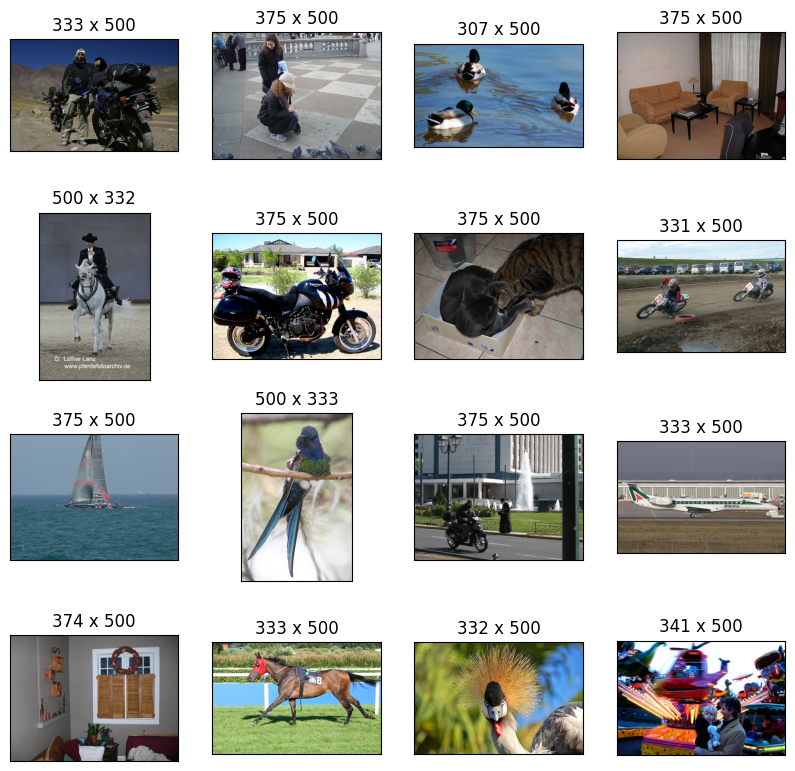

In [2]:
voc_img_dir = os.path.join(".", "data_voc2007", "JPEGImages")
# plot 16 random images in a 4x4 grid

import matplotlib.pyplot as plt
import random
import numpy as np

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i, axi in enumerate(ax.flat):
    img = plt.imread(os.path.join(voc_img_dir, random.choice(os.listdir(voc_img_dir))))
    axi.imshow(img)
    # title with dimensions
    axi.set(xticks=[], yticks=[], title=str(f"{img.shape[0]} x {img.shape[1]}"))

# number of images, maximum dimensions
n_images = len(os.listdir(voc_img_dir))
print(f"No of images: {n_images}")

In [ ]:
# create function to mask images with different shapes and sizes
def mask_image(img, mask, alpha=1):
    """Mask an image with a given mask.
    """
    # create a copy of the image
    img = img.copy()
    # add alpha channel to mask
    mask = np.dstack((mask, mask, mask)) if img.shape[2] == 3 else mask
    # for every pixel in the mask
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            # if pixel is black
            if np.all(mask[row, col] == [0, 0, 0]):
                # set pixel to transparent
                img[row, col] = [0, 0, 0, 0]
            # if pixel is white
            elif np.all(mask[row, col] == [255, 255, 255]):
                # set pixel to image
                img[row, col] = [255, 255, 255, 255]
            # if pixel is grey
            else:
                # blend pixel with image
                img[row, col] = [255, 0, 0, alpha]
    return img

In [60]:
def superpixels_cv(image, num_superpixels=200):
    # Convert the image to the LAB color space
    lab_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2LAB)

    # Perform SLIC superpixel segmentation
    slic = cv2.ximgproc.createSuperpixelSLIC(lab_image, region_size=15, ruler=3)
    slic.iterate(10)

    # Get the superpixel labels
    labels = slic.getLabels()

    # Create a mask for each superpixel
    masks = np.zeros((labels.shape[0], labels.shape[1], num_superpixels), dtype=np.uint8)
    for i in range(num_superpixels):
        masks[:, :, i] = (labels == i).astype(np.uint8) * 255

    return masks

In [71]:
def superpixels_skt(image, num_superpixels=200, num_clusters=3):
    # Convert the image to float and normalize to [0, 1]
    image = img_as_float(image)

    # Perform SLIC superpixel segmentation
    segments = slic(image, n_segments=num_superpixels, compactness=10)

    # Reshape the segmentation to be a 2D array
    segments_2d = segments.reshape(-1, 1)

    # Perform K-means clustering on the superpixel labels
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(segments_2d)

    # Get the cluster labels
    labels = kmeans.labels_

    # Reshape the labels back to the original image shape
    labels = labels.reshape(segments.shape)

    # Create a mask for each cluster
    masks = np.zeros((labels.shape[0], labels.shape[1], num_clusters), dtype=np.uint8)
    for i in range(num_clusters):
        masks[:, :, i] = (labels == i).astype(np.uint8) * 255

    return masks, segments

In [88]:
# create function to generate masks square masks to train on, no more than 50% of the image
def sq_mask(image, max_mask_size=0.3):
    """Generate a square mask for an image.
    """
    # get image dimensions
    height, width = image.shape[:2]
    # Check which dimension is smaller
    if height < width:
        # set mask size to be no more than 50% of the image
        mask_size = np.random.randint(1, int(height * max_mask_size))
    else:
        # set mask size to be no more than 50% of the image
        mask_size = np.random.randint(1, int(width * max_mask_size))    
    
    # generate random coordinates
    x1 = np.random.randint(0, width - mask_size)
    x2 = (x1 + mask_size) 
    y1 = np.random.randint(0, height - mask_size)
    y2 = y1 + mask_size
    print (f"Img dims: {height} x {width}, Mask coords: ({x1}, {x2}), ({y1}, {y2})")	
    # create mask
    mask = np.zeros((height, width))
    mask[y1:y2, x1:x2] = 1
    return mask
# apply mask to image
def apply_mask(image, mask):
    """Apply mask to image.
    """
    masked_image = image.copy()
    masked_image[mask == 1] = 0
    return masked_image

# new folder for masked images
os.makedirs(os.path.join(".", "data_voc2007", "JPEGImages_masked"), exist_ok=True)
# create masked images
for img_name in os.listdir(voc_img_dir):
    # read image
    img = plt.imread(os.path.join(voc_img_dir, img_name))
    # generate mask
    mask = sq_mask(img)
    # apply mask
    masked_img = apply_mask(img, mask)
    # save masked image
    plt.imsave(os.path.join(".", "data_voc2007", "JPEGImages_masked", img_name), masked_img)
    # print progress
    print(f"Masked image {img_name} saved.", end='\r', flush=True)

Img dims: 375 x 500, Mask coords: (53, 182), (21, 150)
Img dims: 333 x 500, Mask coords: (355, 474), (6, 125)
Img dims: 375 x 500, Mask coords: (129, 244), (40, 155)


Img dims: 333 x 500, Mask coords: (353, 498), (132, 277)


ValueError: low >= high